<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Elliptic Equations

Higher dimensional elliptic equations in general have the form
$$
    a_1 u_{xx} + a_2 u_{xy} + a_3 u_{yy} + a_4 u_x + a_5 u_y + a_6 u = f
$$
where the coefficients must satisfy
$$
    a_2^2 - 4 a_1 a_3 < 0.
$$

One natural place again that equations like this come up is again in the steady-state problems arising from the heat equation.  In two dimensions we have
$$
    u_t = (\kappa u_x)_x + (\kappa u_y)_y + \Psi(x,y).
$$
If $u_t = 0$ we then have
$$
    (\kappa u_x)_x + (\kappa u_y)_y = -\Psi(x,y).
$$

If we assume $\kappa$ to be constant we can rewrite this equation as
$$
    u_{xx} + u_{yy} = -\frac{\Psi}{\kappa} = f(x,y)
$$
which is the higher dimensional form of Poisson's equation (and Laplace's equation if $f(x,y) = 0$).

We also must specify a domain $\Omega$ and boundary conditions as before.  Now the boundary conditions will have $x$ and $y$ dependence so will need to be handled a bit differently than before.

## 5-Point Stencil

Extending our work in one-dimension to two we can construct the 5-point stencil for the Laplacian operator as
$$
    \nabla^2 u \approx \frac{U_{i-1,j} - 2 U_{i,j} + U_{i+1,j}}{\Delta x^2} + \frac{U_{i,j-1} - 2 U_{i,j} + U_{i,j+1}}{\Delta y^2}.
$$

If $\Delta x = \Delta y$ we can simplify this expression to
$$
    \nabla^2 u \approx \frac{U_{i-1,j} + U_{i+1,j} - 4 U_{i,j}  + U_{i,j-1} + U_{i,j+1}}{\Delta x^2}
$$

We can the approximate the solution to the Poisson equation as
$$
    \frac{U_{i-1,j} + U_{i+1,j} - 4 U_{i,j}  + U_{i,j-1} + U_{i,j+1}}{\Delta x^2} = f_{i,j}
$$
which leads to $m^2$ equations for $m^2$ unknowns.

## Ordering of Unknowns

We can think of our two-dimensional problem as laying on a grid as in the following figure.  Here the unknows are in red and the boundaries are in blue:
![2D Grid](./images/2d_grid.png)

We can think of the grid as being a matrix like
$$
    U = \begin{bmatrix}
        U_{1, m}   & U_{2, m}   & \cdots & U_{m-1, m}   & U_{m,m}    \\
        U_{1, m-1} & U_{2, m-1} & \cdots & U_{m-1, m-1} & U_{m, m-1} \\
        \vdots & & & & \vdots \\
        U_{1, 2} & U_{2, 2}     & \cdots & U_{m-1, 2}   & U_{m, 2}   \\
        U_{1, 1} & U_{2, 1}     & \cdots & U_{m-1, 1}   & U_{m, 1}   \\
    \end{bmatrix}
$$
It is important to note that this labeling does not match our usual matrix notation!

When we had a single dimension the ordering of the unknowns (and equations) was pretty clear but now we have a number of choices to make.  Perhaps the obvious choice is to break up the 2d array into rows and append each to the end of the previous one.  This leads to the ordering
$$
    U = [U_{1, 1}, U_{2, 1}, \ldots, U_{m-1,1}, U_{m, 1}, U_{1, 2}, U_{22},\ldots, U_{m-1,m}, U_{mm}]
$$

See if you can figure out the structure of the matrix $A$ now with this ordering.

This leads to a matrix of the form
$$
    A = \frac{1}{\Delta x^2} \begin{bmatrix}
        T & I \\
        I & T & I \\
          & I & T & I \\
          &   & \ddots & \ddots & \ddots \\
          &   &        & I & T & I \\
          &   &        &   & I & T
    \end{bmatrix}
$$
where the matrix $T$ is
$$
    T = \begin{bmatrix}
        -4 & 1 \\
        1 & -4 & 1 \\
          & 1 & -4 & 1 \\
          &   & \ddots & \ddots & \ddots \\
          &   &        & 1 & -4 & 1 \\
          &   &        &   & 1 & -4
    \end{bmatrix}
$$
and $I$ is the $m \times m$ identity matrix.

Another possibility is *red-black* ordering (like a checker board).  Here we "color" each unknown in our grid alternating colors, each colored unknown then is grouped together.  

![2D Grid Red-Black Ordering](./images/2d_grid_red_black.png)

Can you figure out what the matrix looks like in this case?

For red-black ordering we are lead to the matrix
$$
    \begin{bmatrix}
        D & H \\
        H^T & D
    \end{bmatrix} \begin{bmatrix}
        U_{\text{red}} \\
        U_{\text{black}}
    \end{bmatrix} =
    \begin{bmatrix}
        f_{\text{red}} \\
        f_{\text{black}}
    \end{bmatrix}
$$
Here $D = -4 / \Delta x^2 I$, a diagonal matrix of dimension $m^2 / 2$ and $H$ a *banded matrix* with 4 non-zero diagonals.

Usually the goal with ordering is either to make the gaps between non-zero elements as small as possible and reduce the amount of "fill-in" when solving using say Gaussian elimination.  This is often taken care of automatically when using sophisticated solving routines.

Solve the following PDE using the ordering of your choice:
$$
    \nabla^2 u = -2\sin x \sin y ~~~ \Omega = [0, 2 \pi] \times [0 , 2 \pi] \\
    u(x,0) = 0, u(x, 2 \pi) = 0, u(0, y) = 0, u(2 \pi, y) = 0.
$$

0.00129000749498


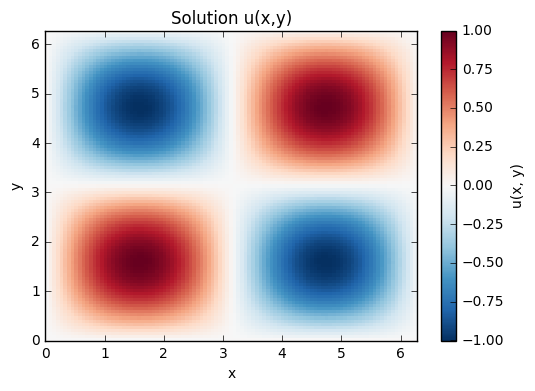

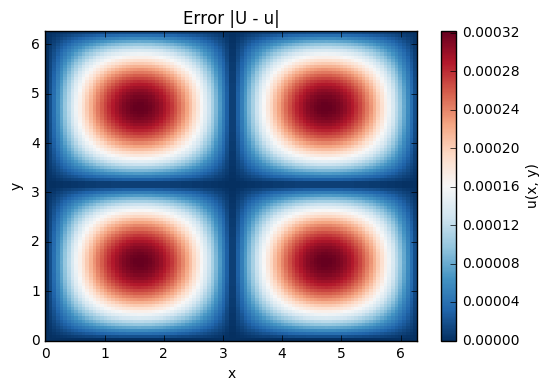

In [2]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

# Problem specification
m = 100
x = numpy.linspace(0, 2.0 * numpy.pi, m + 2)
y = numpy.linspace(0, 2.0 * numpy.pi, m + 2)
delta_x = 2.0 * numpy.pi / (m + 1)

# Construct A
e = numpy.ones(m)
T = sparse.spdiags([e, -4.0 * e, e], [-1, 0, 1], m, m)
S = sparse.spdiags([e, e], [-1, 1], m, m)
I = sparse.eye(m)
A = sparse.kron(I, T) + sparse.kron(S, I)
A /= delta_x**2

# Right-hand-side
X, Y = numpy.meshgrid(x[1:-1], y[1:-1])
f = -2.0 * numpy.sin(X) * numpy.sin(Y)

# Solve
U = numpy.zeros((m+2, m+2))
U[1:-1, 1:-1] = linalg.spsolve(A, f.reshape(m**2, order='F')).reshape((m, m), order='F')

# Error
X, Y = numpy.meshgrid(x, y)
print numpy.linalg.norm((x[1] - x[0]) * (U - numpy.sin(X) * numpy.sin(Y)), ord=1)

# Plot solution
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(X, Y, U, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution u(x,y)")
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_xlim((0.0, 2.0 * numpy.pi))
axes.set_ylim((0.0, 2.0 * numpy.pi))
cbar = fig.colorbar(sol_plot, ax=axes)
cbar.set_label("u(x, y)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(X, Y, numpy.abs(U - numpy.sin(X) * numpy.sin(Y)), cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Error |U - u|")
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_xlim((0.0, 2.0 * numpy.pi))
axes.set_ylim((0.0, 2.0 * numpy.pi))
cbar = fig.colorbar(sol_plot, ax=axes)
cbar.set_label("u(x, y)")
plt.show()

## Accuracy and Stability

We can of course (and should) ask the same questions as with the one-dimensional case, namely whether our scheme will converge.  To do this we need to consider the LTE and the stability of our method.

We know that the LTE is defined as
$$\begin{aligned}
    \tau_{ij} &= \frac{1}{\Delta x^2} (u(x_{i-1}, y_{j}) + u(x_{i+1}, y_{j}) + u(x_{i}, y_{j-1}) + u(x_{i}, y_{j+1}) - 4 u(x_{i}, y_{j})) - f(x_i, y_j)
\end{aligned}$$

To compute this expression we need the Taylor series in each direction.

For the x-direction:
$$\begin{aligned}
    u(x_{i+1}, y_{j}) &= u(x_{i}, y_{j}) + \Delta x u(x_{i}, y_{j})_x + \frac{\Delta x^2}{2} u(x_{i}, y_{j})_{xx} + \frac{\Delta x^3}{6} u(x_{i}, y_{j})_{xxx} + \frac{\Delta x^4}{24} u(x_{i}, y_{j})_{xxxx} + \mathcal{O}(\Delta x^5) \\
    u(x_{i-1}, y_{j}) &= u(x_{i}, y_{j}) - \Delta x u(x_{i}, y_{j})_x + \frac{\Delta x^2}{2} u(x_{i}, y_{j})_{xx} - \frac{\Delta^3}{6} u(x_{i}, y_{j})_{xxx} + \frac{\Delta x^4}{24} u(x_{i}, y_{j})_{xxxx} + \mathcal{O}(\Delta x^5)
\end{aligned}$$

For the y-direction:
$$\begin{aligned}
    u(x_{i}, y_{j+1}) &= u(x_{i}, y_{j}) + \Delta y u(x_{i}, y_{j})_y + \frac{\Delta y^2}{2} u(x_{i}, y_{j})_{yy} + \frac{\Delta y^3}{6} u(x_{i}, y_{j})_{yyy} + \frac{\Delta y^4}{24} u(x_{i}, y_{j})_{yyyy} + \mathcal{O}(\Delta y^5) \\
    u(x_{i}, y_{j-1}) &= u(x_{i}, y_{j}) - \Delta y u(x_{i}, y_{j})_y + \frac{\Delta y^2}{2} u(x_{i}, y_{j})_{yy} - \frac{\Delta y^3}{6} u(x_{i}, y_{j})_{yyy} + \frac{\Delta y^4}{24} u(x_{i}, y_{j})_{yyyy} + \mathcal{O}(\Delta y^5)
\end{aligned}$$

Also using the Taylor expansions in the y-direction we can write the LTE as
$$
    \tau_{ij} =  \frac{1}{12} \Delta x^2 (u_{xxxx} + u_{yyyy}) + \mathcal{O}(\Delta x^4).
$$

The linear system for the LTE then has the form
$$
    A^{\Delta x} E^{\Delta x} = -\tau^{\Delta x}
$$
where now $A$ is the discretization we wrote before.  Note that the ordering of the equations does not matter when considering the error.

For the stability in the 2-norm we again can consider the eigenvalues of the system above.  The eigenvalues are
$$
    \lambda_{pq} = \frac{2}{\Delta x^2} ((\cos(p \pi \Delta x) - 1) + (\cos(q \pi \Delta x) - 1))
$$
with corresponding eigenvectors
$$
    v^{p,q}_{ij} = \sin(p \pi i \Delta x) \sin(q \pi j \Delta x).
$$

Since the eigenvalues are strictly negative ($A$ is in fact negative definite) the closest one to the origin is
$$
    \lambda_{11} = -2 \pi^2 + \mathcal{O}(\Delta x^2)
$$
leading to the spectral radius
$$
    \rho((A^{\Delta x})^{-1}) = \frac{1}{\lambda_{11}} \approx -\frac{1}{2 \pi^2}.
$$
We can use this bound on $A^{-1}$ then to show stability and hence convergence of the discretization.

A similar and useful quantity to consider is the *condition number* of the matrix $A$.  Recall that this can be defined as
$$
    \kappa(A) = ||A|| ||A^{-1}||.
$$

In the 2-norm we already know some information about $A^{-1}$ but we can use our expressions from above to also find the spectral radius of $A$.  The largest eigenvalue there is 
$$
    \lambda_{mm} \approx -\frac{8}{\Delta x^2}
$$
leading to the condition number
$$
    \kappa_2(A) = \frac{4}{\pi^2 \Delta x^2} = \mathcal{O}\left(\frac{1}{\Delta x^2}\right)
$$
This matrix therefore becomes more ill-conditioned as $\Delta x \rightarrow 0$.

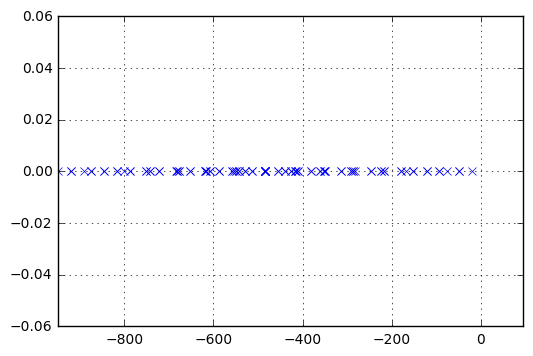

In [14]:
# Compute the eigenvalues
m = 10
delta_x = 1.0 / float(m + 1)
eig_vals = numpy.empty(m**2)
for (i, p) in enumerate(numpy.arange(1, m + 1)):
    for (j, q) in enumerate(numpy.arange(1, m + 1)):
        eig_vals[i * m + j] = 2.0 / delta_x**2 * ((numpy.cos(p * numpy.pi * delta_x) - 1.0) +
                                                  (numpy.cos(q * numpy.pi * delta_x) - 1.0))

# Plot of the eigenvalues of the 5-point Laplacian
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(eig_vals.real, eig_vals.imag, 'x')
axes.grid(True)
axes.set_xlim(numpy.amin(eig_vals), -numpy.amin(eig_vals) * 0.1)
plt.show()

## 9-Point Laplacian

Another approach to discretizing the Laplacian $\nabla^2$ is called the 9-point stencil.  This stencil is defined as
$$
    \nabla^2 u_{ij} = \frac{1}{6 \Delta x^2} \left(4 u_{i-1,j} + 4 u_{i+1,j} + 4 u_{i,j-1} + 4 u_{i,j+1} + u_{i-1,j-1} + u_{i+1,j-1} + u_{i+1,j+1} + u_{i-1,j+1} -20 u_{i,j}  \right).
$$

We can also find the LTE as before to find
$$
    \tau_{ij} = \frac{\Delta x^2}{12} (u_{xxxx} + u_{xxyy} + u_{yyyy}) + \mathcal{O}(\Delta x^4).
$$

So what did we gain?  If we look at $\tau_{ij}$ we can actually write the derivative terms as
$$
    u_{xxxx} + u_{xxyy} + u_{yyyy} = \nabla^2 (\nabla^2 u) \equiv \nabla^4 u,
$$
i.e. the Laplacian of the Laplacian (called the *biharmonic operator*).  If we return to the original PDE, we can directly find the form of this error by noting
$$\begin{aligned}
    \nabla^2 u &= f \\
    \nabla^2 (\nabla^2 u) &= \nabla^2 f
\end{aligned}$$
We can therefore compute the error terms directly by taking the Laplacian of the right hand side of the original PDE!

This also can lead to a higher-order method.  If we define
$$
    f_{ij} = f(x_i, y_j) + \frac{\Delta x^2}{12} \nabla^2 f(x_i, y_j)
$$
we can cancel out the next term of the LTE!  We can even do this if we only have the function $f(x,y)$ on a set of discrete points as we can use the 5-point stencil